In [28]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import sys
import datetime
import matplotlib.pyplot as plt


from pyspark.sql.functions import *


In [29]:
spark = SparkSession \
   .builder \
   .appName("GitHub Archive analysis") \
   .getOrCreate()


In [30]:
spark.sparkContext.setLogLevel('WARN')


In [32]:
gh_data = spark.read.format("json") \
                .load("Downloads/gharchive")


In [33]:
#########  Events with number of times it happened within a day.  #########
daily_events = gh_data.withColumn("Date",substring("created_at",0,10)) \
                        .groupBy("Date", "type") \
                        .agg(count("type").alias("NumberofEvents")) \
                        .orderBy(desc("NumberofEvents"))

daily_events.show()


+----------+--------------------+--------------+
|      Date|                type|NumberofEvents|
+----------+--------------------+--------------+
|2020-06-16|           PushEvent|         41974|
|2020-06-16|         CreateEvent|         17495|
|2020-06-16|    PullRequestEvent|         13734|
|2020-06-16|   IssueCommentEvent|          5343|
|2020-06-16|          WatchEvent|          4110|
|2020-06-16|         DeleteEvent|          2956|
|2020-06-16|         IssuesEvent|          2346|
|2020-06-16|PullRequestReview...|          1871|
|2020-06-16|           ForkEvent|          1723|
|2020-06-16|         MemberEvent|           302|
|2020-06-16|        ReleaseEvent|           287|
|2020-06-16|         PublicEvent|           262|
|2020-06-16|         GollumEvent|           245|
|2020-06-16|  CommitCommentEvent|           194|
+----------+--------------------+--------------+



In [43]:
#########  Organizations, repositories, or users with most commits. ########

most_active_repositories_self_owned_repos = gh_data.filter(col("org").isNull()) \
                                    .withColumn("commits", explode("payload.commits")) \
                                    .groupBy("repo.name") \
                                    .agg(countDistinct("commits.sha").alias("NumberofCommits")) \
                                    .withColumnRenamed("name","repository_name") \
                                    .orderBy(desc("NumberofCommits"))

most_active_repositories_self_owned_repos.show()

most_active_organizations = gh_data.filter(col("org").isNotNull()) \
                                    .withColumn("commits", explode("payload.commits")) \
                                    .groupBy("org.login") \
                                    .agg(countDistinct("commits.sha").alias("NumberofCommits")) \
                                    .withColumnRenamed("login","organization_name") \
                                    .orderBy(desc("NumberofCommits"))

most_active_organizations.show()

most_active_users = gh_data.withColumn("commits", explode("payload.commits")) \
                                    .groupBy("commits.author.name") \
                                    .agg(countDistinct("commits.sha").alias("NumberofCommits")) \
                                    .withColumnRenamed("name","UserName") \
                                    .orderBy(desc("NumberofCommits"))
most_active_users.show()


+--------------------+---------------+
|     repository_name|NumberofCommits|
+--------------------+---------------+
|multicharts/scann...|            339|
|          brand22/d3|            316|
|javierluraschi/covid|            173|
| thearthouse/kcmxpro|            144|
|chrisotto6/chriso...|            140|
|BlondelSeumo/On-D...|            133|
|      akkt2620/ntdtv|            127|
|        akkt2620/djy|            125|
|    x9mdwe5q/ncovlog|            120|
|tbutler1132/ttt-6...|            115|
|            otiny/up|            110|
|nikkamille/ruby-m...|            101|
|hkristin/ruby-mus...|             73|
|taroxd/rootdouble-CN|             67|
|zescalli/python-l...|             67|
|  pequet/public-logs|             65|
|songkamongkol/jen...|             61|
|   GitClock/GitClock|             60|
|shirellsin/shirel...|             60|
|      himobi/hotspot|             60|
+--------------------+---------------+
only showing top 20 rows

+--------------------+---------------+

In [35]:
##########  Public/Private repositories metrics. ########

events_for_repository_type = gh_data.groupBy("public") \
                        .agg(count("type").alias("NumberofEvents")) \
                        .orderBy(desc("NumberofEvents"))

events_for_repository_type.show()


+------+--------------+
|public|NumberofEvents|
+------+--------------+
|  true|         92842|
+------+--------------+



In [42]:
#########  Most used words in commit message. ###########
most_used_commit_words = gh_data.withColumn("commits", explode("payload.commits")) \
                                .withColumn("words_of_commits", explode(split(regexp_replace("commits.message","[ ]+"," "), " "))) \
                                .groupBy("words_of_commits") \
                                .agg(count(lit(1)).alias("Count_of_word")) \
                                .orderBy(desc("Count_of_word"))

most_used_commit_words.show(30)


+----------------+-------------+
|words_of_commits|Count_of_word|
+----------------+-------------+
|              to|        15853|
|             the|         9661|
|            from|         9164|
|          Update|         7113|
|             for|         6886|
|             and|         6529|
|           Merge|         6086|
|              in|         5547|
|              of|         5523|
|               a|         4176|
|          update|         4004|
|             Add|         3936|
|              by|         3774|
|         request|         3478|
|            pull|         3395|
|              up|         3090|
|              on|         2804|
|          branch|         2656|
|              is|         2616|
|             add|         2561|
|            with|         2541|
|   Automatically|         2401|
|          backed|         2389|
|           Learn|         2388|
|            into|         2298|
|               -|         2074|
|             new|         1982|
|         

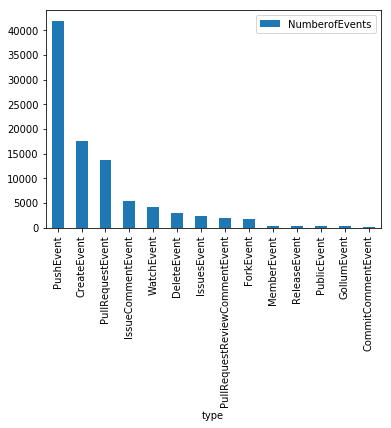

In [37]:
daily_events_pd = daily_events.toPandas()

daily_events_pd.plot(kind='bar',x='type',y='NumberofEvents')
plt.show()


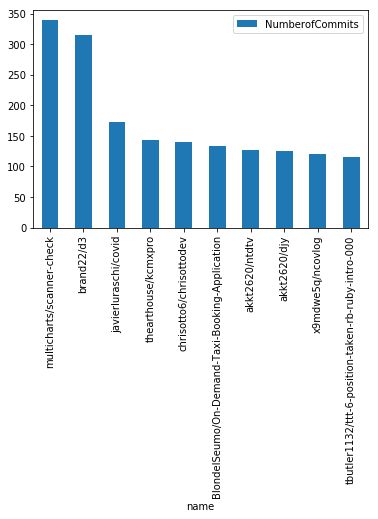

In [38]:
most_active_repositories_self_owned_repos_pd = most_active_repositories_self_owned_repos.limit(10).toPandas()
most_active_repositories_self_owned_repos_pd.plot(kind='bar',x='name',y='NumberofCommits')
plt.show()


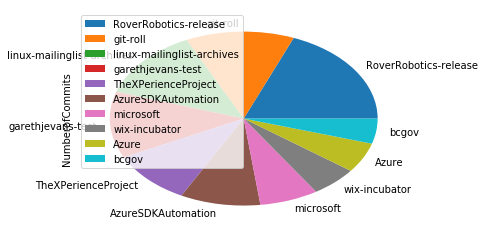

In [39]:
most_active_organizations_pd = most_active_organizations.limit(10).toPandas()
most_active_organizations_pd.plot(kind='pie',labels=most_active_organizations_pd['login'],legend=True, y="NumberofCommits")
plt.show()

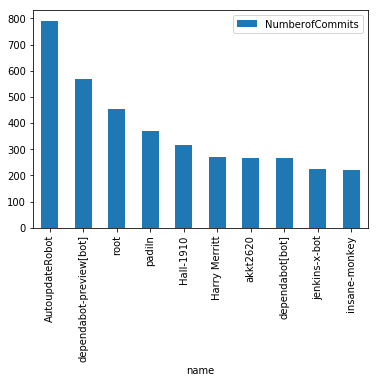

In [40]:
most_active_users_pd = most_active_users.limit(10).toPandas()
most_active_users_pd.plot(kind='bar',x='name',y='NumberofCommits')
plt.show()

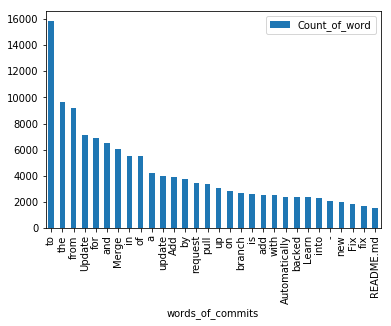

In [41]:
most_used_commit_words_pd = most_used_commit_words.limit(30).toPandas()
most_used_commit_words_pd.plot(kind='bar',x='words_of_commits',y='Count_of_word')
plt.show()